<a href="https://colab.research.google.com/github/chitransh-singhal/Data-Science/blob/master/Looking_for_Port_Boundaries_in_AIS_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Looking for Port Boundaries

In [1]:
import pandas as pd
import geopandas as gpd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [2]:
import requests, zipfile, io

url = 'https://coast.noaa.gov/htdata/CMSP/AISDataHandler/2021/AIS_2021_01_01.zip'

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [3]:
df = pd.read_csv("/content/AIS_2021_01_01.csv")

In [4]:
df.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
0,338325166,2021-01-01T00:00:20,28.08771,-82.77474,0.0,0.0,511.0,SALT WIFE,IMO0000000,NaN,37.0,NaN,13.0,6.0,NaN,NaN,B
1,368163740,2021-01-01T00:00:18,26.10727,-80.12551,0.0,360.0,511.0,TOTALLY EXCELLENT,IMO0000000,WDL7818,37.0,NaN,18.0,4.0,NaN,NaN,B
2,366811570,2021-01-01T00:00:23,30.66150,-88.03264,0.0,196.0,270.0,NATALIE H,IMO7200245,WDA4637,31.0,0.0,18.0,7.0,NaN,NaN,A
3,368140750,2021-01-01T00:00:24,30.23140,-93.25791,0.0,50.5,272.0,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,A
4,368170010,2021-01-01T00:00:28,29.57223,-90.59391,0.0,316.2,197.0,NaN,NaN,NaN,NaN,13.0,NaN,NaN,NaN,NaN,A


In [5]:
df.size

112621804

In [6]:
df_clean = df.dropna(axis=0, how="any", inplace=False)
df_clean.drop_duplicates(keep='first', inplace=True)
df = pd.DataFrame()

<ipython-input-6-b21ef6917718>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean.drop_duplicates(keep='first', inplace=True)


In [7]:
df_clean.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
19,366550000,2021-01-01T00:00:32,29.12197,-90.19797,0.0,108.5,160.0,PAT TILLMAN,IMO9421374,WNSF,90.0,0.0,76.0,17.0,5.0,99.0,A
25,366983530,2021-01-01T00:00:53,33.73351,-118.16958,0.4,87.1,179.0,JOHN QUIGG,IMO8987929,WDB9828,31.0,0.0,24.0,9.0,4.0,52.0,A
26,303422000,2021-01-01T00:00:58,34.15152,-119.20693,0.0,290.8,89.0,SEA VENTURE,IMO9347413,WDC5952,90.0,5.0,106.0,21.0,6.9,90.0,A
38,518630000,2021-01-01T00:00:10,25.72142,-77.75589,10.4,328.5,332.0,BETTY K VIII,IMO8410328,E5U2577,70.0,8.0,77.0,13.0,4.1,70.0,A
78,366755010,2021-01-01T00:02:00,33.74129,-118.19444,0.0,202.3,225.0,MASTER,IMO9188532,WCY6528,31.0,0.0,32.0,10.0,6.8,52.0,A


<Axes: xlabel='LAT', ylabel='LON'>

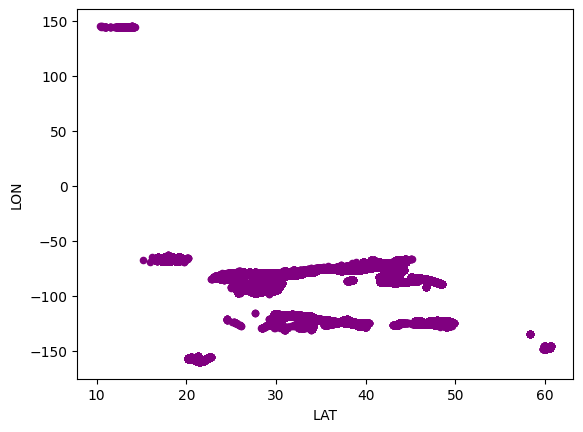

In [8]:
df_clean.plot.scatter(x='LAT', y='LON', c='Purple')

In [9]:
# very slow is < 0.5 knots
df_slow = df_clean[df_clean.SOG < 0.5]

In [10]:
df_slow.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
19,366550000,2021-01-01T00:00:32,29.12197,-90.19797,0.0,108.5,160.0,PAT TILLMAN,IMO9421374,WNSF,90.0,0.0,76.0,17.0,5.0,99.0,A
25,366983530,2021-01-01T00:00:53,33.73351,-118.16958,0.4,87.1,179.0,JOHN QUIGG,IMO8987929,WDB9828,31.0,0.0,24.0,9.0,4.0,52.0,A
26,303422000,2021-01-01T00:00:58,34.15152,-119.20693,0.0,290.8,89.0,SEA VENTURE,IMO9347413,WDC5952,90.0,5.0,106.0,21.0,6.9,90.0,A
78,366755010,2021-01-01T00:02:00,33.74129,-118.19444,0.0,202.3,225.0,MASTER,IMO9188532,WCY6528,31.0,0.0,32.0,10.0,6.8,52.0,A
89,316001940,2021-01-01T00:01:09,42.28600,-83.11958,0.0,241.9,352.0,FLORENCE SPIRIT,IMO9314600,CFCB,70.0,0.0,136.0,21.0,8.3,79.0,A


In [11]:
df_slow['LAT'].max(), df_slow['LAT'].min()

(58.32438, 13.45566)

In [12]:
df_slow['LON'].max(), df_slow['LON'].min()

(144.66938, -158.11635)

<Axes: xlabel='LAT', ylabel='LON'>

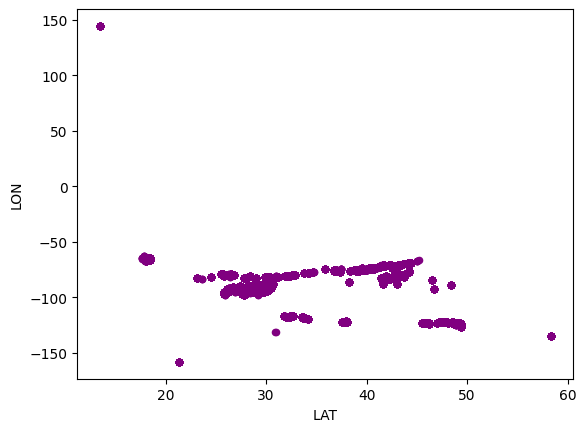

In [13]:
df_slow.plot.scatter(x='LAT', y='LON', c='Purple')

In [14]:
df_slow.shape

(456327, 17)

In [15]:
df_slow_reduced = df_slow[(df_slow['LAT'] < 30) & (df_slow['LAT'] > 20) & (df_slow['LON'] < -80) & (df_slow['LON'] > -90)]

In [16]:
df_slow_reduced.shape

(55854, 17)

In [17]:
df_slow_reduced.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
118,236111758,2021-01-01T00:00:28,28.90966,-89.35243,0.1,346.0,126.0,IVER BEST,IMO9588275,ZDKN7,70.0,1.0,109.0,18.0,6.6,89.0,A
403,339474000,2021-01-01T00:00:17,26.10296,-80.12033,0.1,243.3,82.0,MARCATO,IMO9408669,6YSP8,37.0,1.0,42.0,9.0,2.4,37.0,A
469,339396000,2021-01-01T00:00:58,26.74888,-80.04959,0.1,191.1,178.0,GIGI,IMO9557513,6YSA8,37.0,5.0,49.0,9.0,2.4,37.0,A
618,538080049,2021-01-01T00:01:16,25.78626,-80.18029,0.0,259.7,354.0,MY SEANNA,IMO9024152,V7KQ7,37.0,0.0,48.0,9.0,1.9,37.0,A
630,367550000,2021-01-01T00:00:07,28.41361,-80.62113,0.0,139.0,511.0,GO NAVIGATOR,IMO9566887,WDK3552,90.0,0.0,45.0,11.0,3.0,90.0,A


In [18]:
#pick location for folium map
latitude = 26
longitude = -86

In [19]:
DFW_Map = folium.Map(
    location=[latitude, longitude],
    zoom_start = 10)

In [20]:
# map vessels with folim -- use VesselName as label
slow_vessels = folium.map.FeatureGroup()
latitudes = list(df_slow_reduced.LAT)
longitudes = list(df_slow_reduced.LON)
labels = list(df_slow_reduced.VesselName)
for lat,lng, label in zip(latitudes, longitudes, labels):
    folium.Marker(
        location = [lat, lng],
        popup = label,
        icon = folium.Icon(color='red', icon='info-sign')
    ).add_to(DFW_Map)

In [21]:
# DFW_Map

###Clustering Algorithm - DBSCAN

In [22]:
df_slow_reduced.head()

,MMSI,BaseDateTime,LAT,LON,SOG,COG,Heading,VesselName,IMO,CallSign,VesselType,Status,Length,Width,Draft,Cargo,TranscieverClass
118,236111758,2021-01-01T00:00:28,28.90966,-89.35243,0.1,346.0,126.0,IVER BEST,IMO9588275,ZDKN7,70.0,1.0,109.0,18.0,6.6,89.0,A
403,339474000,2021-01-01T00:00:17,26.10296,-80.12033,0.1,243.3,82.0,MARCATO,IMO9408669,6YSP8,37.0,1.0,42.0,9.0,2.4,37.0,A
469,339396000,2021-01-01T00:00:58,26.74888,-80.04959,0.1,191.1,178.0,GIGI,IMO9557513,6YSA8,37.0,5.0,49.0,9.0,2.4,37.0,A
618,538080049,2021-01-01T00:01:16,25.78626,-80.18029,0.0,259.7,354.0,MY SEANNA,IMO9024152,V7KQ7,37.0,0.0,48.0,9.0,1.9,37.0,A
630,367550000,2021-01-01T00:00:07,28.41361,-80.62113,0.0,139.0,511.0,GO NAVIGATOR,IMO9566887,WDK3552,90.0,0.0,45.0,11.0,3.0,90.0,A


In [23]:
coords = df_slow_reduced[['LAT', 'LON']].to_numpy()

In [24]:
# first DBSCAN with epsilon = 1.5 km
kms_per_radian = 6371.0088
epsilon = 1.5 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 70


In [25]:
df_slow_reduced['label1'] = cluster_labels

<ipython-input-25-c3c45e191477>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slow_reduced['label1'] = cluster_labels


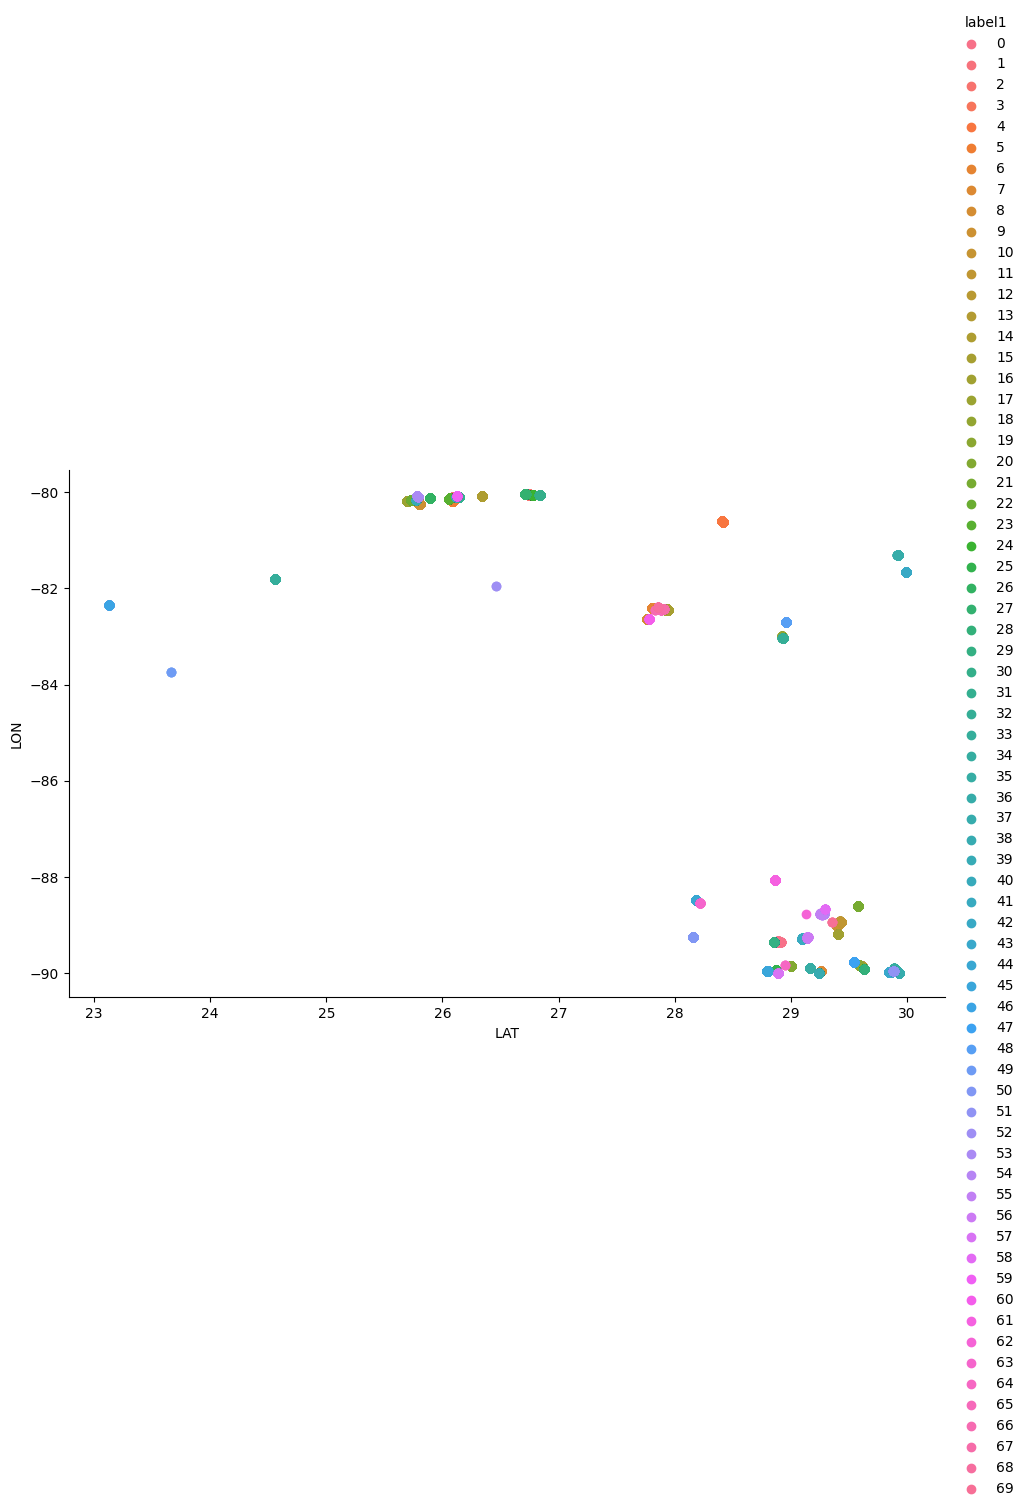

In [26]:
#plot label 1
fg = sns.FacetGrid(data=df_slow_reduced, hue='label1', height=6, aspect=1.61)
fg.map(plt.scatter, 'LAT', 'LON').add_legend()

In [27]:
# second DBSCAN with epsilon = 20 km
kms_per_radian = 6371.0088
epsilon = 20 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 23


<ipython-input-28-884e585da2b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slow_reduced['label2'] = cluster_labels


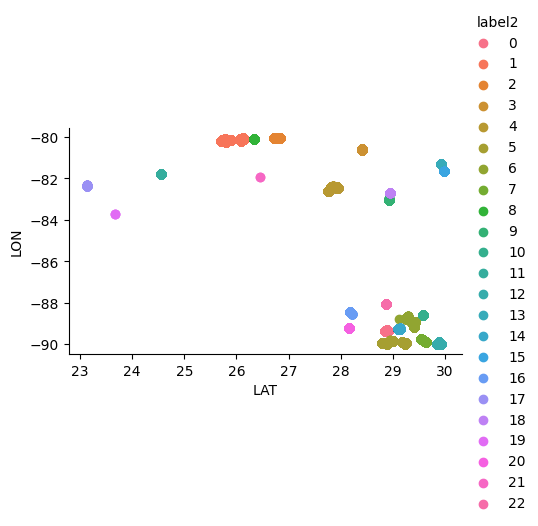

In [28]:
df_slow_reduced['label2'] = cluster_labels

#plot label 2
fg = sns.FacetGrid(data=df_slow_reduced, hue='label2', aspect=1.61)
fg.map(plt.scatter, 'LAT', 'LON').add_legend()

In [29]:
# third DBSCAN with epsilon = 60 km
kms_per_radian = 6371.0088
epsilon = 60 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 13


<ipython-input-30-a667bd79e11e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slow_reduced['label3'] = cluster_labels


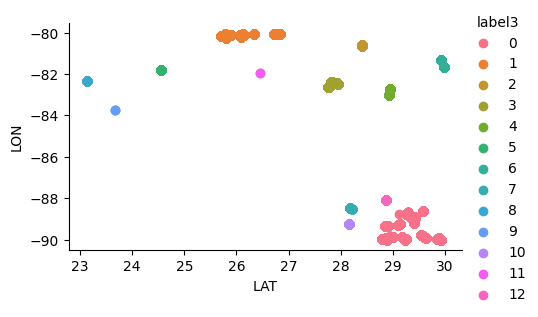

In [30]:
df_slow_reduced['label3'] = cluster_labels

#plot label 3
fg = sns.FacetGrid(data=df_slow_reduced, hue='label3', aspect=1.61)
fg.map(plt.scatter, 'LAT', 'LON').add_legend()